## CSE 6367 Programming Assignment 4 (P4)
## Fall 2023
## Panorama

## Dataset

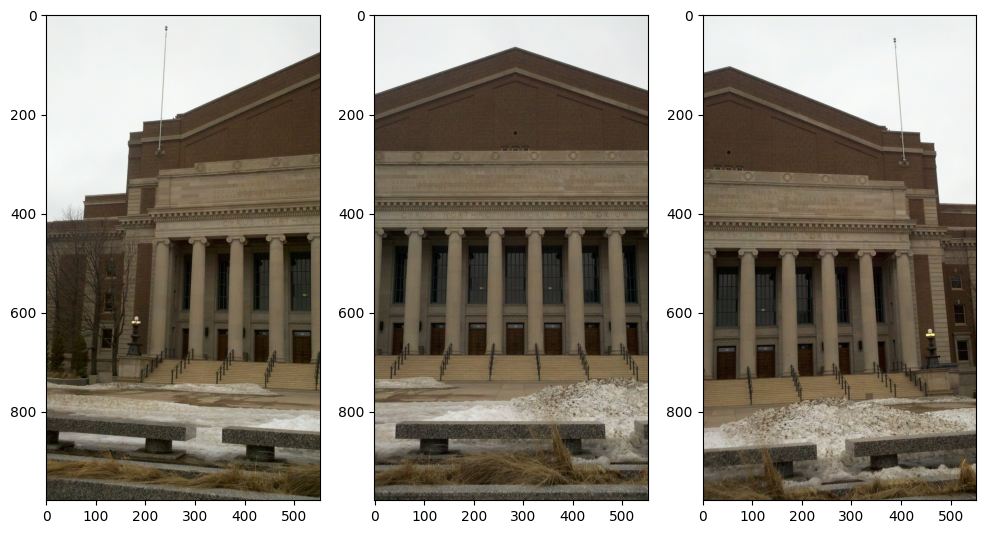

In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 12 ,8

# read images
img1 = cv2.imread("Images/mall1.jpg")
img2 = cv2.imread("Images/mall2.jpg")
img3 = cv2.imread("Images/mall3.jpg")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)

## Assignment Instructions:

In this assignment, you will perform image stitching and create a panorama of stitched images. Here are some basic steps you need to perform for image stiching:

    1. Detecting keypoints (DoG, Harris, etc.) and extracting local invariant descriptors (SIFT, SURF, ORB etc.) from two input images
    2. Matching the descriptors between the images
    3. Estimate a homography matrix using our matched feature vectors
    4. Applying a warping transformation using the homography matrix obtained from Step #3
    
<b> You may use opencv or other libraries for doing different tasks of this programming assignment.<\b>

### Import Libraries required

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

### 1. Detecting Keypoints
In this step we make use of OpenCV's ORB (Oriented FAST and Rotated BRIEF) to extract keypoints from mall1 and mall2 images.
The idea is to first stitch mall1 with mall2 and then to stitch the combination of mall1 and mall2 with mall3.

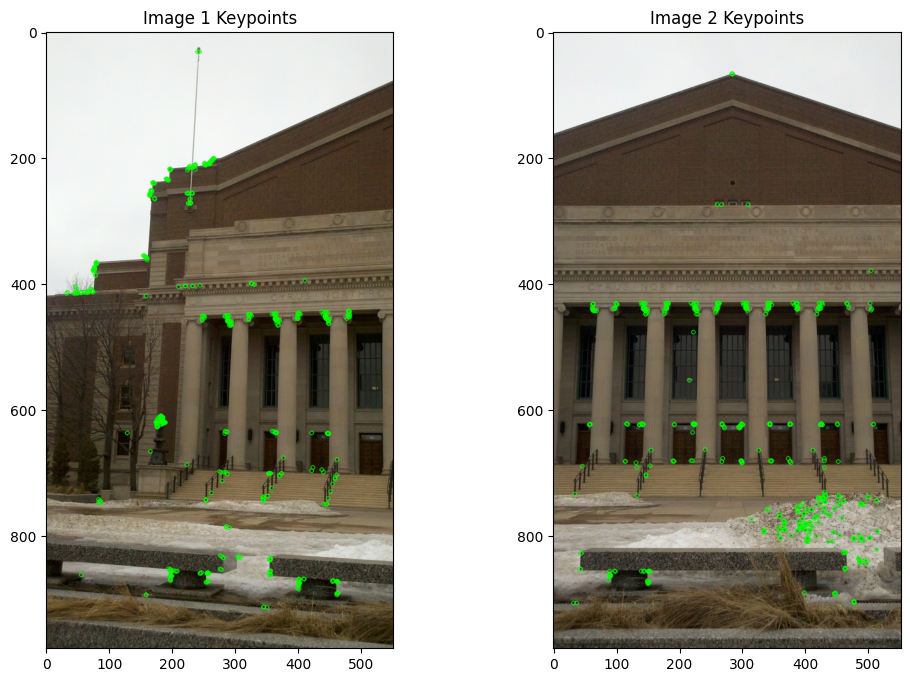

In [3]:
rcParams['figure.figsize'] = 12, 8

img1 = cv2.imread("./Images/mall1.jpg")
img2 = cv2.imread("./Images/mall2.jpg")
img3 = cv2.imread("./Images/mall3.jpg")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

orb = cv2.ORB_create()

keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

img1_keypoints = cv2.drawKeypoints(img1, keypoints1, None, color=(0, 255, 0), flags=0)
img2_keypoints = cv2.drawKeypoints(img2, keypoints2, None, color=(0, 255, 0), flags=0)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1_keypoints)
ax[0].set_title("Image 1 Keypoints")
ax[1].imshow(img2_keypoints)
ax[1].set_title("Image 2 Keypoints")
plt.show()

### 2. Matching descriptors between images
I make use of OpenCV's BFMatcher (Brute Force) and use NORM_HAMMING as the normType. This gives us an images that shows what descriptors in mall1 matches with descriptors in mall2.

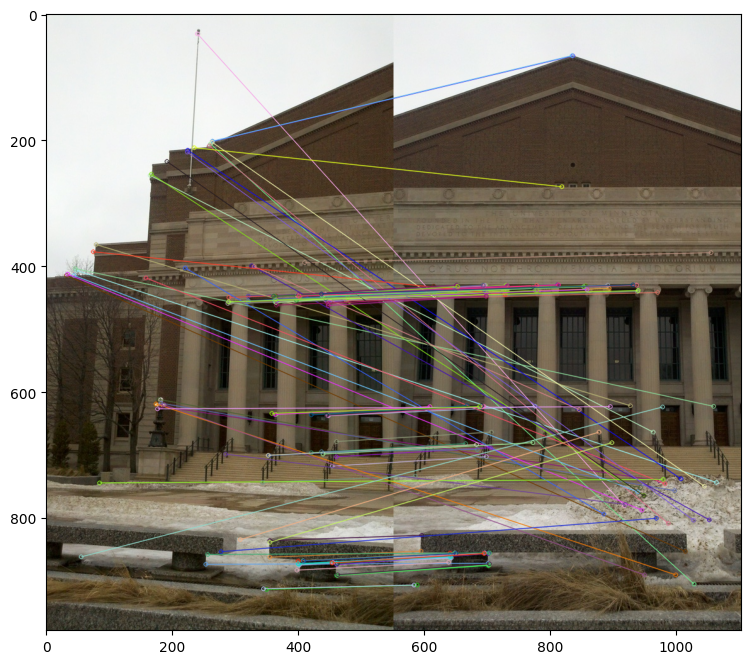

In [4]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_matches)
plt.show()

### 3. Estimate homography matrix
In this steps, we use the matching keypoints and find the homography matrix using OpenCV's findHomography function that uses RANSAC algorithm. This also makes sure to eliminate any outlying matching keypoints for smooth stitching.

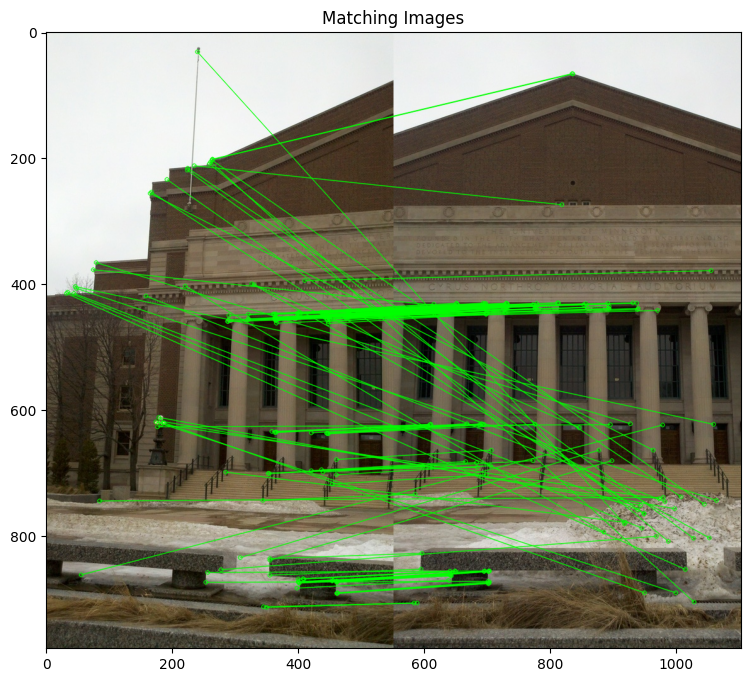

In [5]:
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

homography_matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

matches_mask = None
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matches_mask, flags=2)
img_matches_ransac = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, **draw_params)

plt.title("Matching Images")
plt.imshow(img_matches_ransac)
plt.show()

### 4. Applying a warping transformation
A function is written that will stitch two input images based on the homography matrix provided. This will return a stitched image.

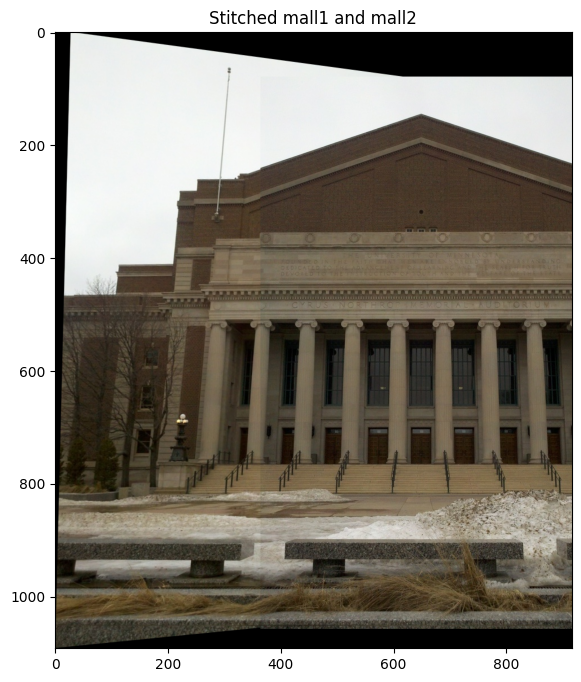

In [6]:
def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    warped_corners2 = cv2.perspectiveTransform(corners2, H)

    corners = np.concatenate((corners1, warped_corners2), axis=0)
    [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)

    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

    warped_img2 = cv2.warpPerspective(img2, Ht @ H, (xmax - xmin, ymax - ymin))
    warped_img2[t[1]:h1 + t[1], t[0]:w1 + t[0]] = img1

    return warped_img2

warped_img = warp_images(img2, img1, homography_matrix)

plt.title("Stitched mall1 and mall2")
plt.imshow(warped_img)
plt.show()

### Repeat the process
Now, we repeat the process with mall3 to stitch it with the result of the previous step to obtain the full panorama.

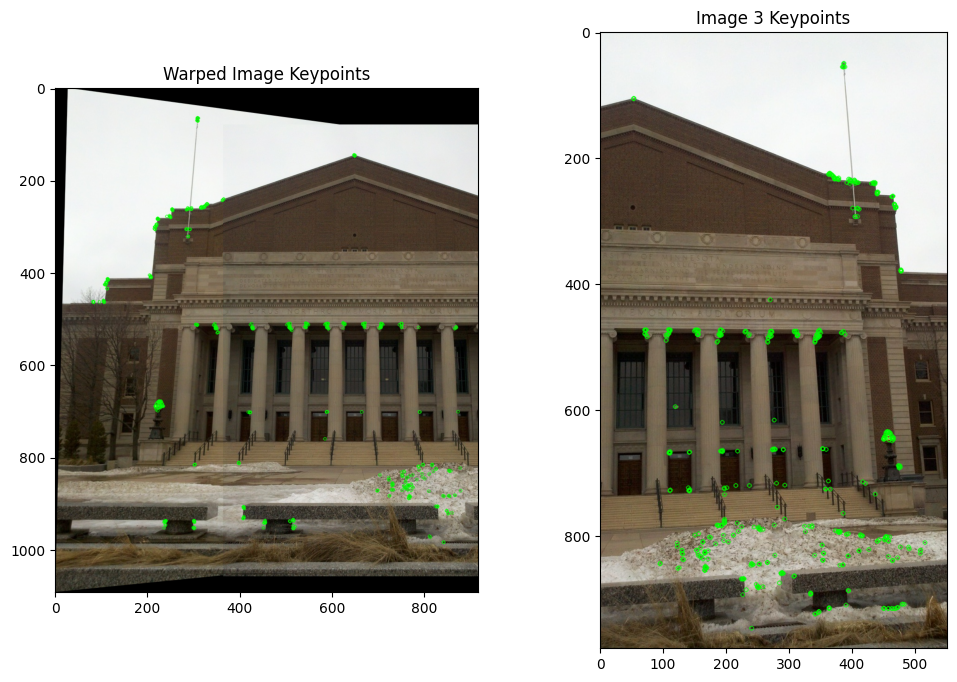

In [7]:
orb = cv2.ORB_create()

keypoints12, descriptors12 = orb.detectAndCompute(warped_img, None)
keypoints3, descriptors3 = orb.detectAndCompute(img3, None)

warped12_keypoints = cv2.drawKeypoints(warped_img, keypoints12, None, color=(0, 255, 0), flags=0)
img3_keypoints = cv2.drawKeypoints(img3, keypoints3, None, color=(0, 255, 0), flags=0)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(warped12_keypoints)
ax[0].set_title("Warped Image Keypoints")
ax[1].imshow(img3_keypoints)
ax[1].set_title("Image 3 Keypoints")
plt.show()

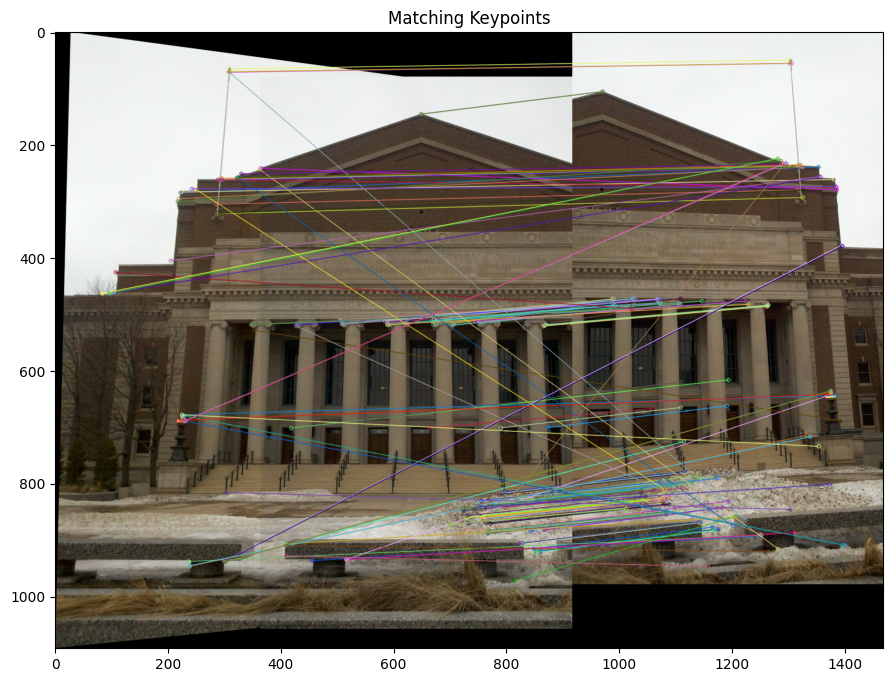

In [8]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches12_3 = bf.match(descriptors12, descriptors3)

matches12_3 = sorted(matches12_3, key=lambda x: x.distance)

img_matches12_3 = cv2.drawMatches(warped_img, keypoints12, img3, keypoints3, matches12_3, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.title("Matching Keypoints")
plt.imshow(img_matches12_3)
plt.show()

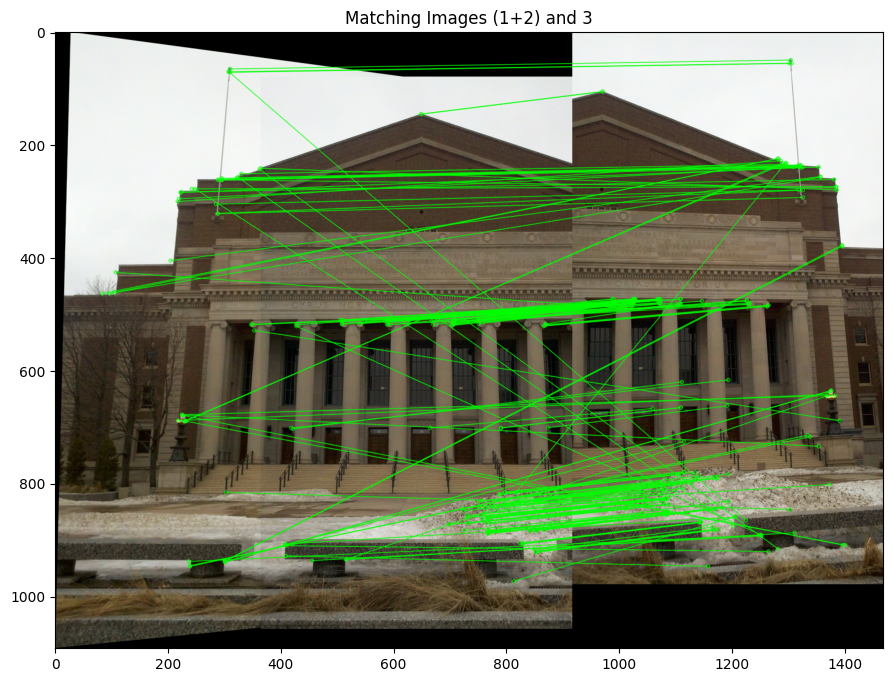

In [9]:
src_pts12 = np.float32([keypoints12[m.queryIdx].pt for m in matches12_3]).reshape(-1, 1, 2)
dst_pts3 = np.float32([keypoints3[m.trainIdx].pt for m in matches12_3]).reshape(-1, 1, 2)

homography_matrix12_3, _ = cv2.findHomography(src_pts12, dst_pts3, cv2.RANSAC, 5.0)

matches_mask12_3 = None
draw_params12_3 = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matches_mask12_3, flags=2)
img_matches12_3_ransac = cv2.drawMatches(warped_img, keypoints12, img3, keypoints3, matches12_3, None, **draw_params12_3)

plt.title("Matching Images (1+2) and 3")
plt.imshow(img_matches12_3_ransac)
plt.show()

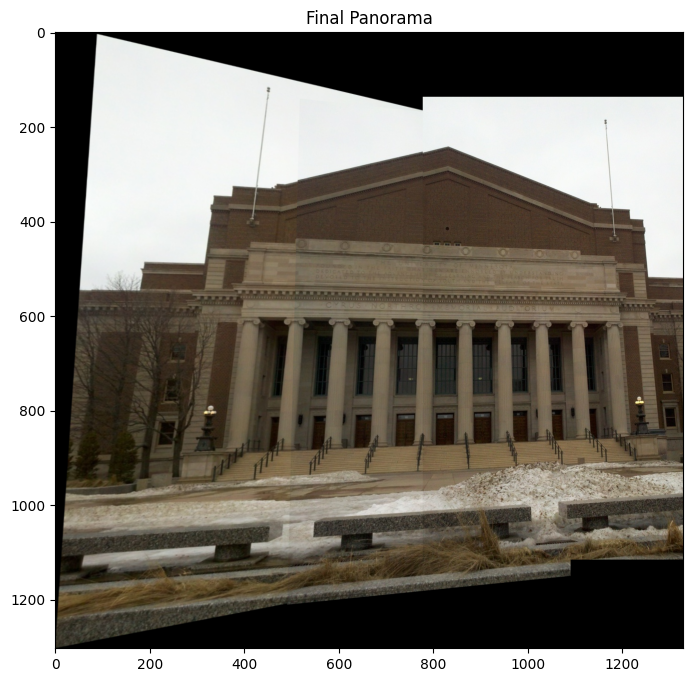

In [10]:
final_stitched_img = warp_images(img3, warped_img, homography_matrix12_3)


plt.title("Final Panorama")
plt.imshow(final_stitched_img)
plt.show()

### Submission Guidelines:
        
        Submit through Canvas your source code in a single .ipynb file. 
        The name of the .ipynb file should be YourStudentID.ipynb. (For example: 1001234567.ipynb)
        The images are available in the ./Images directory. Your TA will use the same directory name to grade your submission.
        You don't need to attach the images folder with your submission.